### DATA 643 Project 3: Part 2 ALS (Alternate Least Square Matrix Factorization)
_Nathan, Angas, Pavan_

In the second part of project 3, we tried ALS method based on a reference material in below section. <br>
We experimented the ALS method using nested for loops and have the codes running without errors. The recommendations given by the algorithm seems to be reasonable.However the codes do not provide intuitive understanding of the machanics under the hood. ALS method works by finding Local Minima which is similar to optimization problem. We use 20 iterations as part of 3 parameters: lamda, number of factors and iterations. The iteration took 2 hours to run on 16GB RAM footprints. 

In [66]:
from surprise import SVD, evaluate, KNNBasic, Dataset, similarities, Reader
from surprise.model_selection import GridSearchCV, cross_validate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
#import math
from tabulate import tabulate
#%matplotlib inline

Read Data in as dataframe format from github repository.

In [41]:
df1 = pd.read_csv('https://raw.githubusercontent.com/angus001/Data643/master/Project2/ratings2.csv', sep=',')
movie_names = pd.read_csv ('https://raw.githubusercontent.com/angus001/Data643/master/Project2/movies.csv',sep = ',')
algo = SVD()
df1.head()


,userId,movieId,Id2,rating,timestamp
0,7,1,1,3.0,851866703
1,9,1,1,4.0,938629179
2,13,1,1,5.0,1331380058
3,15,1,1,2.0,997938310
4,19,1,1,3.0,855190091


In [5]:
movie_names.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The following is using suprise package's SVD

In [47]:
reader = Reader(rating_scale = (1,5))
df1a = df1[['userId','Id2','rating']].head(9000)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

df2 = Dataset.load_from_df(df1a[['userId','Id2','rating']], reader)
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(df2)
#print(gs.best_score['rmse'])
print('BEST RMSE: %f' %(gs.best_score['rmse']))
print(gs.best_params['rmse'])

BEST RMSE: 0.924968
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


Data wrangling for ALS algorithm starts here. <br>
1) First, the rating data is merged with the movie title so that we can see how each user rated the movie s/he saw. 

In [3]:

movie_rating_matrix = pd.merge(df1,movie_names, on = 'movieId')
movie_rating_matrix.head()

,userId,movieId,Id2,rating,timestamp,title,genres
0,7,1,1,3.0,851866703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,9,1,1,4.0,938629179,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,13,1,1,5.0,1331380058,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,1,2.0,997938310,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,19,1,1,3.0,855190091,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


2) The movie title with the new ID is then selected from step 1 to remove duplicate and sequential index for each title

In [9]:
df5 = movie_rating_matrix[['Id2','title']]

movie_names_ID2 = df5.drop_duplicates()
movie_names_ID2.head()

,Id2,title
0,1,Toy Story (1995)
247,2,Jumanji (1995)
354,3,Grumpier Old Men (1995)
413,4,Waiting to Exhale (1995)
426,5,Father of the Bride Part II (1995)


In [5]:
df3 = movie_rating_matrix[['userId','Id2','rating','title']]
df3.head()

,userId,Id2,rating,title
0,7,1,3.0,Toy Story (1995)
1,9,1,4.0,Toy Story (1995)
2,13,1,5.0,Toy Story (1995)
3,15,1,2.0,Toy Story (1995)
4,19,1,3.0,Toy Story (1995)


In [13]:
# rename the dataframe column for better readability
df3.rename(columns={'Id2':'movie_id'},inplace =True)
df3.head()

C:\Users\Angus\Documents\Winpython32\WinPython-32bit-3.6.3.0Qt5\python-3.6.3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,userId,movie_id,rating,title
0,7,1,3.0,Toy Story (1995)
1,9,1,4.0,Toy Story (1995)
2,13,1,5.0,Toy Story (1995)
3,15,1,2.0,Toy Story (1995)
4,19,1,3.0,Toy Story (1995)


A pivot table function is used to create different matrixes. The first matrix has users as the columns while the second matrix has the movie as the column. These two matrixes are created for user-user filtering verus item-item based filtering. A small slice of the second matrix is shown in the next output.

In [6]:
rating_matrix = df3.pivot_table(values = 'rating', index='title', columns = 'userId', fill_value = 0)
rating_matrix1 = df3.pivot_table(values = 'rating', index='userId', columns = 'title', fill_value = 0)

In [7]:

# Pivot the data frame to produce a matrix format dataset.
rating_matrix1.iloc[:5,:5]


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986)
userId,,,,,
1,0.0,0.0,0,0.0,0.0
2,0.0,0.0,0,0.0,0.0
3,0.0,0.0,0,0.0,0.0
4,0.0,0.0,0,0.0,0.0
5,0.0,0.0,0,0.0,0.0


In [48]:
#turn the "movie title" column to a list for retrival later

movie_titles = movie_names_ID2.title.tolist()
Q = rating_matrix1.values
Q.shape

(671, 9064)

In [49]:
# binary check to create a matrix with binary data
W = Q>0.5
W[W == True] = 1
W[W == False] = 0
# Change the data type to float to match with Q matrix
W = W.astype(np.float64, copy=False)

In [13]:
#set parameters

lambda_ = 0.1
n_factors = 100
m,n = Q.shape
n_iterations = 20

X = 5 * np.random.rand(m, n_factors) # five does not really matter here. 
Y = 5 * np.random.rand(n_factors, n)

# Functions to get error between ratings
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

In [58]:
errors = []
for ii in range(n_iterations):
    X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(n_factors), 
                        np.dot(Y, Q.T)).T
    Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(n_factors),
                        np.dot(X.T, Q))
    if ii % 100 == 0:
        print('{}th iteration is completed'.format(ii))
    errors.append(get_error(Q, X, Y, W))
Q_hat = np.dot(X, Y)
print('Error of rated movies: {}'.format(get_error(Q, X, Y, W)))

0th iteration is completed


Error of rated movies: 285586.8544909717


In [60]:
errors[1]

286487.84199009306

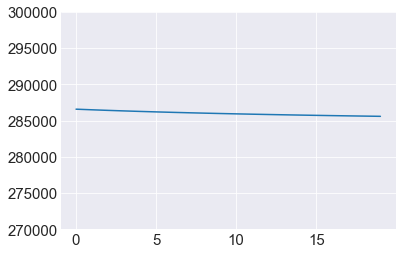

In [64]:
#plot error
sns.set_style('darkgrid')
plt.plot(errors)
plt.ylim([270000,300000])
plt.show()

In [37]:
def print_recommendations(nm, W=W, Q=Q, Q_hat=Q_hat, movie_titles=movie_titles ):
    #Q_hat -= np.min(Q_hat)
    #Q_hat[Q_hat < 1] *= 5
    Q_hat -= np.min(Q_hat)
    Q_hat *= float(5) / np.max(Q_hat)
    movie_ids = np.argmax(Q_hat - 5 * W, axis=1)
    i = 0
    
    for jj, movie_id in zip(range(m), movie_ids):
            if i < nm:
                #if Q_hat[jj, movie_id] < 0.1: continue
                print('User {} liked {}\n'.format(jj + 1, ', '.join([movie_titles[ii] for ii, qq in enumerate(Q[jj]) if qq > 3])))
                print('User {} did not like {}\n'.format(jj + 1, ', '.join([movie_titles[ii] for ii, qq in enumerate(Q[jj]) if qq < 3 and qq != 0])))
                print('\n User {} recommended movie is {} - with predicted rating: {}'.format(
                            jj + 1, movie_titles[movie_id], Q_hat[jj, movie_id]))
                print('\n' + 100 *  '-' + '\n')
                i+= 1

In [16]:
weighted_errors = []
for ii in range(n_iterations):
    for u, Wu in enumerate(W):
        X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
                               np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    for i, Wi in enumerate(W.T):
        Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
    weighted_errors.append(get_error(Q, X, Y, W))
    print('{}th iteration is completed'.format(ii))
weighted_Q_hat = np.dot(X,Y)

0th iteration is completed


1th iteration is completed


2th iteration is completed


3th iteration is completed


4th iteration is completed


5th iteration is completed


6th iteration is completed


7th iteration is completed


8th iteration is completed


9th iteration is completed


10th iteration is completed


11th iteration is completed


12th iteration is completed


13th iteration is completed


14th iteration is completed


15th iteration is completed


16th iteration is completed


17th iteration is completed


18th iteration is completed


19th iteration is completed


In [65]:
print_recommendations(nm = 5, Q_hat=weighted_Q_hat)



User 1 liked Tender Mercies (1983), Dark Half, The (1993), Paper Chase, The (1973), Not Suitable for Children (2012)

User 1 did not like Terminal Velocity (1994), Chamber, The (1996), Swingers (1996), Primary Colors (1998), Crocodile Dundee (1986), Dracula (1931), Terrorist, The (a.k.a. Malli) (Theeviravaathi) (1998), Honeymoon in Vegas (1992), Replacements, The (2000), Kick-Ass (2010), Sessions, The (Surrogate, The) (2012), Partisan (2015)


 User 1 recommended movie is Kung Fu Panda: Secrets of the Furious Five (2008) - with predicted rating: 3.182061894779596

----------------------------------------------------------------------------------------------------

User 2 liked Paris, France (1993), To Catch a Thief (1955), Band Wagon, The (1953), Smilla's Sense of Snow (1997), Double Team (1997), 'burbs, The (1989), Indiana Jones and the Temple of Doom (1984), Needful Things (1993), Legend (1985), Leatherface: Texas Chainsaw Massacre III (1990), Emperor and the Assassin, The (Jing ke c

#Reference: <br>

1) https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/